In [2]:
import numpy as np
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

In [3]:
class Model:

    def __init__(self,rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol):
        
        self.rstar = rstar # pH=0のときの、定常状態での名目金利の値
        self.bet = bet # 割引率
        self.phi = phi # テイラー係数
        self.kap = kap # フィリップス曲線の傾き
        self.sH = sH # 状態Hでの自然利子率の値
        self.sL = sL # 状態Lでの自然利子率の値
        self.pH = pH # 危機が起こる確率
        self.pL = pL # 危機の継続確率
        self.maxiter = maxiter # 繰り返し回数の最大値
        self.tol = tol # 許容誤差

In [4]:
def dist(x0,sH,pH,pL,bet,phi,rstar,yLtar,piLtar):
    """
    ----------------------------------------------------------------
    === 所与のパラメータから得られるモデルの値とターゲット値との距離 ===
    ----------------------------------------------------------------
    ※カリブレーションで用いる関数
    ※調整するパラメータ:{sL,kap}
    ※ターゲット:{yL,piL}
    <input>
    ・x0: [sL,kap]を含むベクトル(調整するパラメータ)
    ・sH: 状態Hでの自然利子率の値
    ・pH: 危機が起こる確率
    ・pL: 危機の継続確率
    ・bet: 割引率
    ・phi: テイラー係数
    ・rstar: pH=0のときの、定常状態での名目金利の値
    ・yLtar: 状態Lでの生産ギャップのターゲット
    ・piLtar: 状態Lでのインフレ率のターゲット
    <output>
    ・f: 所与のパラメータから得られるモデルの値とターゲット値との距離(の二乗和)
    """
    # 最適化問題を解くために引数をベクトルにする必要がある。
    sL = x0[0]
    kap = x0[1]

    # 解析的解({yH,yL,piH,piL}についての連立方程式を解くことで解を求める)
    # Ax = b を解く。x=[yH;yL;piH;piL] である。 
    # A:係数行列
    A = np.array([[-1+(1-pH), pH, -(phi-1)*(1-pH), -(phi-1)*pH],
    [(1-pL), -1+pL, (1-pL), pL],
    [kap, 0, -1+bet*(1-pH), bet*pH],
    [0, kap, bet*(1-pL), -1+bet*pL]])
    # b: 定数項のベクトル
    b = np.array([[rstar-sH],[-sL],[0],[0]])
    x = np.linalg.inv(A) @ b

    yL = x[1]
    piL = x[3]

    # データの値とモデルの値の間の距離を求める
    f = (yL-yLtar)**2 + (piL-piLtar)**2

    return f

In [5]:
from numpy.lib import issubdtype


def ti(m):
    """
    ---------------------------------------
    === 時間反復法によってモデルを解く関数 ===
    ---------------------------------------
    <input>
    ・m: パラメータを含むコンストラクタ
    <output>
    ・yvec0: 均衡での生産ギャップ
    ・pvec0: 均衡でのインフレ率
    ・rvec0: 均衡での名目金利
    """

    # STEP 1(a): グリッド生成
    Gs = np.array([m.sH, m.sL]) # 外生的ショック
    Ps = np.array([[1-m.pH, m.pH],
                  [1-m.pL, m.pL]]) # ショックの遷移行列
    
    # STEP 1(b): 政策関数の初期値を当て推量
    Ns = 2
    # 適当な初期値
    yvec0 = np.zeros(Ns)
    pvec0 = np.zeros(Ns)
    rvec0 = np.zeros(Ns)
    yvec1 = np.zeros(Ns)
    pvec1 = np.zeros(Ns)
    rvec1 = np.zeros(Ns)

    # STEP 4: 政策関数を繰り返し計算
    diff = 1e+4 # 政策関数の繰り返し誤差
    iter = 1 # ループ・カウンター

    while diff>m.tol:

        for iss in range(Ns): # Pythonではループにおけるインデックスをissにしている
            
            # ショックの値
            s0 = Gs[iss]

            # 古い政策関数から期待値(ye,pie)を計算
            ye = Ps[iss,:].T @ yvec0
            pie = Ps[iss,:].T @ pvec0

            # 期待値を所与として最適化
            r0 = max(m.rstar + m.phi*pie, 0.0)
            y0 = ye - (r0 - pie - s0)
            p0 = m.kap*y0 + m.bet*pie

            # 新しい政策関数を保存
            yvec1[iss] = y0
            pvec1[iss] = p0
            rvec1[iss] = r0

        # 繰り返し計算誤差を確認
        ydiff = np.max(abs(yvec1-yvec0))
        pdiff = np.max(abs(pvec1-pvec0))
        rdiff = np.max(abs(rvec1-rvec0))
        diff = max(ydiff, pdiff, rdiff)

        # 政策関数をアップロード
        yvec0 = np.copy(yvec1)
        pvec0 = np.copy(pvec1)
        rvec0 = np.copy(rvec1)

        iter += 1
    
    return yvec0, pvec0, rvec0

In [6]:
rstar = 0.75 # pH=0のときの、定常状態での名目金利の値
bet = 1/(1+rstar/100) # 割引率(オイラー方程式の定常状態より)
phi = 5.0  # テイラー係数(注: 小さいとiL=0にならない)
pL = 0.75  # 危機の継続確率
sH = rstar # 状態Hでの自然利子率の値

# カリブレーション
# yLとpiLのターゲットにpH=0のときのモデルの値を合わせるように、sLとkapの値をセット

pH = 0.0 # 危機が起こる確率
x0 = [-2.0, 0.01] # sLとkapの初期値

# yLとpiLのターゲット
yLtar = -7.0
piLtar = -1.0/4

# 最小化関数(Pythonの場合fminを用いる。これはNelder-Mead法で多次元の最小化問題を解いている。)
dist1 = lambda x: dist(x,sH,pH,pL,bet,phi,rstar,yLtar,piLtar)
res = fmin(dist1,x0,disp=False)

# カリブレートしたパラメータをセット
sL = res[0]  # 状態Lでの自然利子率の値
kap = res[1] # フィリップス曲線の傾き

maxiter = 2000 # 繰り返し回数の最大値
tol = 1e-5 # 許容誤差

In [7]:
# pH=0.0 のケースで数値解を計算する
pH = 0.0
# 構造体にパラメータを格納
m = Model(rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol)

start = time.time() # 実行時間を計測する
yvec0, pvec0, rvec0 = ti(m)
end = time.time()

print(f"{end-start:.6f} seconds")

0.001999 seconds


In [26]:
# pH=0.025 のケースで数値解を計算する
pH = 0.025
# 構造体にパラメータを格納
m = Model(rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol)

start1 = time.time() # 実行時間を計測する
yvec1, pvec1, rvec1 = ti(m)
end1 = time.time()

print(f"{end1-start1:.6f} seconds")

0.039069 seconds


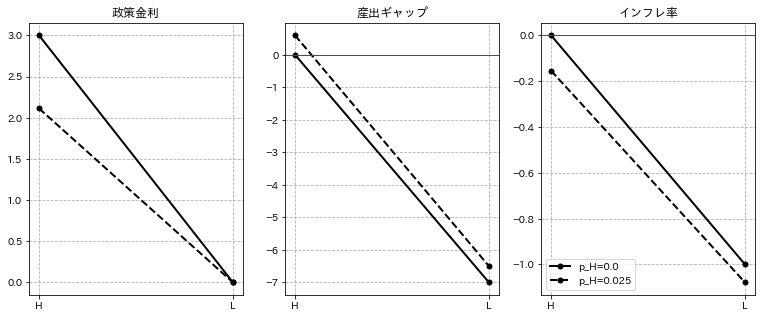

In [59]:
fig, ax = plt.subplots(1,3, figsize=(13,5))

ax[0].plot([1,2],rvec0*4,ls="-",marker=".",c="k",lw=2,markersize=10)
ax[0].plot([1,2],rvec1*4,ls="--",marker=".",c="k",lw=2,markersize=10)
ax[0].set(title="政策金利",xticks=[1,2],xticklabels=["H","L"])
ax[0].grid(ls="--")

ax[1].plot([1,2],yvec0,ls="-",marker=".",c="k",lw=2,markersize=10)
ax[1].plot([1,2],yvec1,ls="--",marker=".",c="k",lw=2,markersize=10)
ax[1].axhline(y=0,c="r",lw=1)
ax[1].set(title="産出ギャップ",xticks=[1,2],xticklabels=["H","L"])
ax[1].grid(ls="--")

ax[2].plot([1,2],pvec0*4,ls="-",marker=".",c="k",lw=2,markersize=10,label="p_H=0.0")
ax[2].plot([1,2],pvec1*4,ls="--",marker=".",c="k",lw=2,markersize=10,label="p_H=0.025")
ax[2].axhline(y=0,c="r",lw=1)
ax[2].set(title="インフレ率",xticks=[1,2],xticklabels=["H","L"])
ax[2].grid(ls="--")
ax[2].legend(loc="lower left")

plt.show()